# Predicting Vaccination Likelihood

## Business Understanding

In light of their new vaccination initiative, the CDC has conducted surveys on random individuals throughout the country. In this notebook, we use the survey results to deliver a predictive binary classifier model to the stakeholder (CDC) that determines if someone will take the Seasonal Flu vaccine based on responses to a phone survey. Predictions on future surveys can help assess public health risk by determining the percent of the population likely to get vaccinated.

Let's start by importing modules necessary for analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, roc_auc_score, plot_roc_curve, roc_curve,auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

## Data Cleaning & Exploration

The first step is to import the dataset and remove columns that are not related to seasonal vaccination and have a high percentage of missing values.

In [2]:
df_var = pd.read_csv('data/training_set_features.csv')
df_tar = pd.read_csv('data/training_set_labels.csv')['seasonal_vaccine']
df_var = df_var.drop(['respondent_id','h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','doctor_recc_h1n1','hhs_geo_region'],axis=1)
df_var = df_var.drop(['health_insurance','income_poverty','employment_industry','employment_occupation'],axis=1)

Next, let's perform a train-test split. 

In [3]:
X_train,X_test,y_train,y_test = train_test_split(df_var,df_tar,random_state=42)
X_train = X_train.copy(deep=True)

### Preprocessing

In the below cell, we are using pipelines and transformers to impute, encode and scale the training set. 

In [4]:
majority_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                     'behavioral_face_mask', 'behavioral_wash_hands',
                     'behavioral_large_gatherings', 'behavioral_outside_home',
                     'behavioral_touch_face', 'doctor_recc_seasonal',
                     'chronic_med_condition', 'child_under_6_months', 'health_worker',
                     'education', 'rent_or_own', 'marital_status', 'employment_status',
                     'sex'
                  ]
opinion_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','household_adults', 'household_children'
                   ]
ohe_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','age_group','education','race',
                   'employment_status', 'census_msa'
                   ]

non_imputed_columns = ['age_group','race','census_msa']

oe_columns = ['sex','marital_status','rent_or_own']


col_imputer = ColumnTransformer(transformers=[
    ("sim", SimpleImputer(strategy='most_frequent'), majority_columns),

    ("sib", SimpleImputer(strategy='median'), opinion_columns)

    ],
    remainder="passthrough")

col_ohe = ColumnTransformer(transformers=[
    ('oe' , OrdinalEncoder(categories='auto'), oe_columns),
    ("ohe", OneHotEncoder(categories="auto", drop='first'), ohe_columns)
    ], 
    remainder='passthrough')
# Create a pipeline containing the single column transformer

pipe1 = Pipeline(steps=[
    ('col_imputer', col_imputer)
])

imputed = pipe1.fit_transform(X_train)
X_train_pipe_impute = pd.DataFrame(imputed, columns=majority_columns+opinion_columns+non_imputed_columns)

pipe2 = Pipeline(steps=[
    ('col_ohe', col_ohe),
    ('ss', StandardScaler())
])

# Use the pipeline to fit and transform the data
transformed_train_data = pipe2.fit_transform(X_train_pipe_impute)

encoder = col_ohe.named_transformers_['ohe']
category_labels = encoder.get_feature_names(ohe_columns)

# Make a dataframe with the relevant columns
X_train_pipe_processed = pd.DataFrame(transformed_train_data, columns=oe_columns+list(category_labels)+list(X_train_pipe_impute.drop(ohe_columns+oe_columns, axis=1).columns))

# Sex - 0=Female | 1=Male
# Marital Status - 0=Married | 1=Not Married
# Rent or Own - 0=Own | 1=Rent

In the below cell, we are using the pipelines and transformers created above to impute, encode and scale the test set. 

In [5]:
imputed_X_test = pipe1.transform(X_test)
X_test_pipe_impute = pd.DataFrame(imputed_X_test, columns=majority_columns+opinion_columns+non_imputed_columns)
transformed_test_data = pipe2.transform(X_test_pipe_impute)
X_test_pipe_processed = pd.DataFrame(transformed_test_data, columns=oe_columns+list(category_labels)+list(X_test_pipe_impute.drop(ohe_columns+oe_columns, axis=1).columns))

# Modeling

## Baseline Model 

The team decided to use a dummy model that always predicts the most frequent target variable value as a baseline model.

In [6]:
dc = DummyClassifier(strategy='most_frequent',random_state=42)
dc.fit(X_train_pipe_processed,y_train)
cross_val_score(dc,X_train_pipe_processed,y_train,cv=5,scoring='roc_auc').mean()

0.5

The average cross validation Receiver Operating Characteristic (ROC) area under curve (AUC) is 0.5 (50%). Let's also look at the test ROC AUC.

In [7]:
roc_auc_score(y_test,dc.predict(X_test_pipe_processed))

0.5

The test ROC AUC is also 50%. Let's see what the ROC curve looks like.

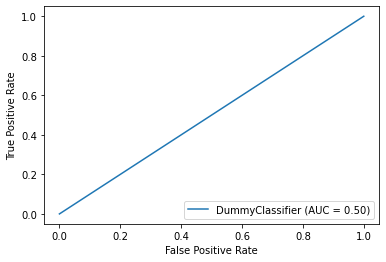

In [8]:
plot_roc_curve(dc,X_train_pipe_processed,y_train);

This is a binary classification problem, so this baseline model is as good as randomly guessing the target variable. Let's look at some classification methods to see if we can obtain a better model.

### One Feature Logistic Regression Model


The team decided to select a logistic regression utilizing a single feature as the first classification model to try. The team chose logistic regression as it is a simple classification algorithm and the model will have only one feature as multicolinearity issues were encountered that will be explained shortly. 

Let's start by using grid search to find the optimal hyperparameters to use in the logistic regression.

In [9]:
logreg_l1 = LogisticRegression()

param_grid = {
    'C': np.linspace(1e-5,1,50),
    'solver': ['liblinear','saga'],
    'penalty': ['l1']
}

gs_logreg_l1 = GridSearchCV(logreg_l1, param_grid, cv=3)
gs_logreg_l1.fit(X_train_pipe_processed, y_train)

gs_logreg_l1.best_params_

{'C': 0.08164183673469387, 'penalty': 'l1', 'solver': 'saga'}

Next, let's perform Recursive Feature Elimination (RFE) in order to find the single best feature to use, 

In [10]:
lr_cv_rfe = []
lr_keep_lists = []
num_features_to_select = 1
lr_rfe = LogisticRegression(penalty='l1',solver='saga',C = 0.08164183673469387)
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_pipe_processed, y=y_train)
feature_list = [(k,v) for k,v in zip(X_train_pipe_processed.columns,select.support_)]
current_keep_list = []
for k,v in feature_list:
    if v:
        current_keep_list.append(k)
    
current_cv = cross_val_score(lr_rfe,X_train_pipe_processed[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

lr_cv_rfe.append(current_cv)
lr_keep_lists.append(current_keep_list)

Now that we have the best feature and the best hyperparameters, we can generate the model and analyze it's performance. 

In [11]:
logreg_final = LogisticRegression(penalty='l1',solver='saga',C = 0.08164183673469387)
logreg_final.fit(X_train_pipe_processed[lr_keep_lists[0]],y_train)
cross_val_score(lr_rfe,X_train_pipe_processed[lr_keep_lists[0]],y_train,cv=5,scoring='roc_auc').mean()

0.6797286000175904

The average cross validation Receiver Operating Characteristic (ROC) area under curve (AUC) is 0.68 (68%). Let's also look at the test ROC AUC.

In [12]:
roc_auc_score(y_test,logreg_final.predict(X_test_pipe_processed[lr_keep_lists[0]]))

0.6785140829544462

The test ROC AUC is 68%. The train and test ROC AUC are almost identical, so this model is not overfit or underfit.

Let's also visualize the Receiver Operating Characteristic ROC curve.

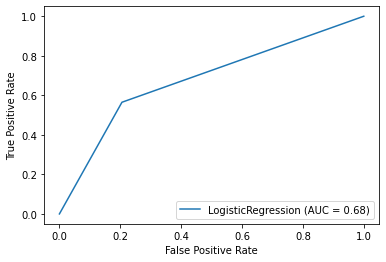

In [13]:
plot_roc_curve(logreg_final,X_train_pipe_processed[lr_keep_lists[0]],y_train);

Finally, let's look at the confusion matrix to see how the model did on the training set.

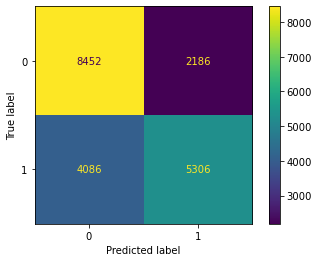

In [14]:
plot_confusion_matrix(logreg_final,X_train_pipe_processed[lr_keep_lists[0]],y_train);

This model shows significant improvement compared to the baseline model in predicting both the training and test sets. So, the team attempted to continue improving this model by adding more features, however, high multicollinearity was observed between many variables that were significant predictors of the target variable. Therefore, the team decided to use a decision tree as a step-up model and leave the one-feature logistic regression as is. More details on the multicollinearity analysis can be found in the appendix folder of this repository.

# Step-up Model: Decision Tree

The team decided to use a decision tree as a step-up model as it is immune to multicolinearity, easy to visualize and easy to interpret. To keep the model inferential, only top five features will be used.

Let's start by using grid search to find the optimal hyperparameters to use in the decision tree.

In [15]:
dt = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [30,35,40,45],
    'random_state': [0,10,20]
}

gs_dt = GridSearchCV(dt, param_grid_dt, cv=5)
gs_dt.fit(X_train_pipe_processed, y_train)
gs_dt.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 35,
 'random_state': 0}

In order to find the top five features to use, let's perform Recursive Feature Elimination (RFE) for Decision Tree in the cell below.

In [16]:
# Recursive Feature Elimination for Decision Tree
dt_cv_rfe = []
dt_keep_lists = []
max_features = 5
for n in range(1,max_features+1):
    num_features_to_select = n
    dt_rfe = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
    select = RFE(dt_rfe, n_features_to_select=num_features_to_select)
    select.fit(X=X_train_pipe_processed, y=y_train)
    feature_list = [(k,v) for k,v in zip(X_train_pipe_processed.columns,select.support_)]
    current_keep_list = []
    for k,v in feature_list:
        if v:
            current_keep_list.append(k)
    
    current_cv = cross_val_score(dt_rfe,X_train_pipe_processed[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

    dt_cv_rfe.append(current_cv)
    dt_keep_lists.append(current_keep_list)

Next, let's plot the relationship between number of features and mean Cross Val Receiver Operating Characteristic (ROC) area under curve (AUC).

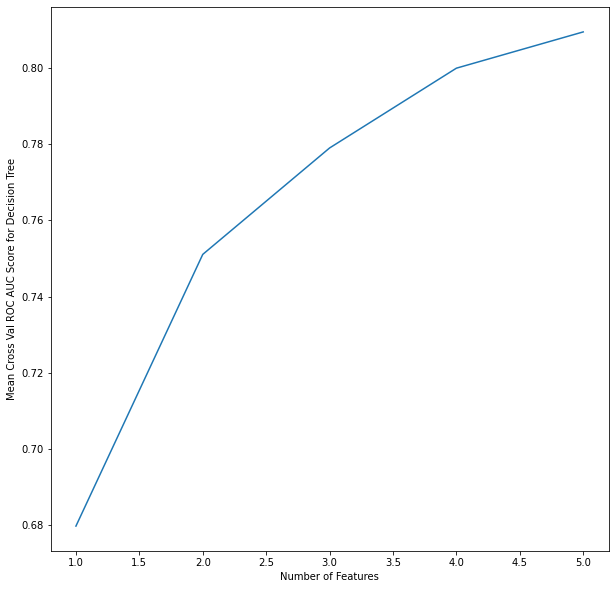

In [17]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range(1,max_features+1),dt_cv_rfe)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Mean Cross Val ROC AUC Score for Decision Tree')
plt.show()

It appears that five features yields the maximum ROC AUC value.

Now that we have the top five features and the best hyperparameters, we can generate the model and analyze it's performance.

In [18]:
dt_final = DecisionTreeClassifier(criterion = 'gini',max_depth = 8,min_samples_split = 35,random_state = 0)
dt_final.fit(X_train_pipe_processed[dt_keep_lists[4]],y_train)
cross_val_score(dt_final,X_train_pipe_processed[dt_keep_lists[4]],y_train,cv=5,scoring='roc_auc').mean()

0.8098404021135082

The average cross validation ROC AUC is 0.81 (81%) which is considerably higher than the average cross validation ROC AUC of the one feature logistic regression model (68%).

Let's also look at the test ROC AUC.

In [19]:
roc_auc_score(y_test,dt_final.predict(X_test_pipe_processed[dt_keep_lists[4]]))

0.7517924606959032

The test ROC AUC is 75.2%. Although the model is slightly overfitting, this model has a higher test ROC AUC than the one feature logistic regression model (68%).  

Let's look at the confusion matrix to see how the model did on the training set.

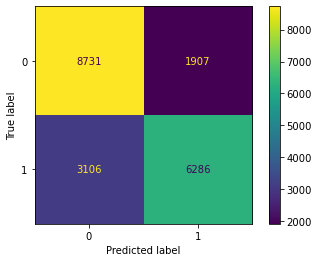

In [20]:
plot_confusion_matrix(dt_final,X_train_pipe_processed[dt_keep_lists[4]],y_train)

Let's now plot the ROC curve to visualize the area under the curve (AUC).

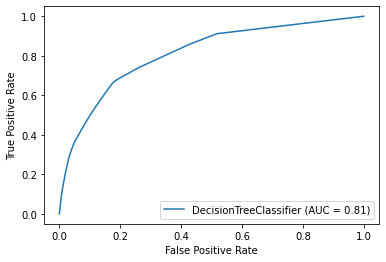

In [21]:
plot_roc_curve(dt_final,X_train_pipe_processed[dt_keep_lists[4]],y_train)

Finally, let's visualize the tree generated by the model.

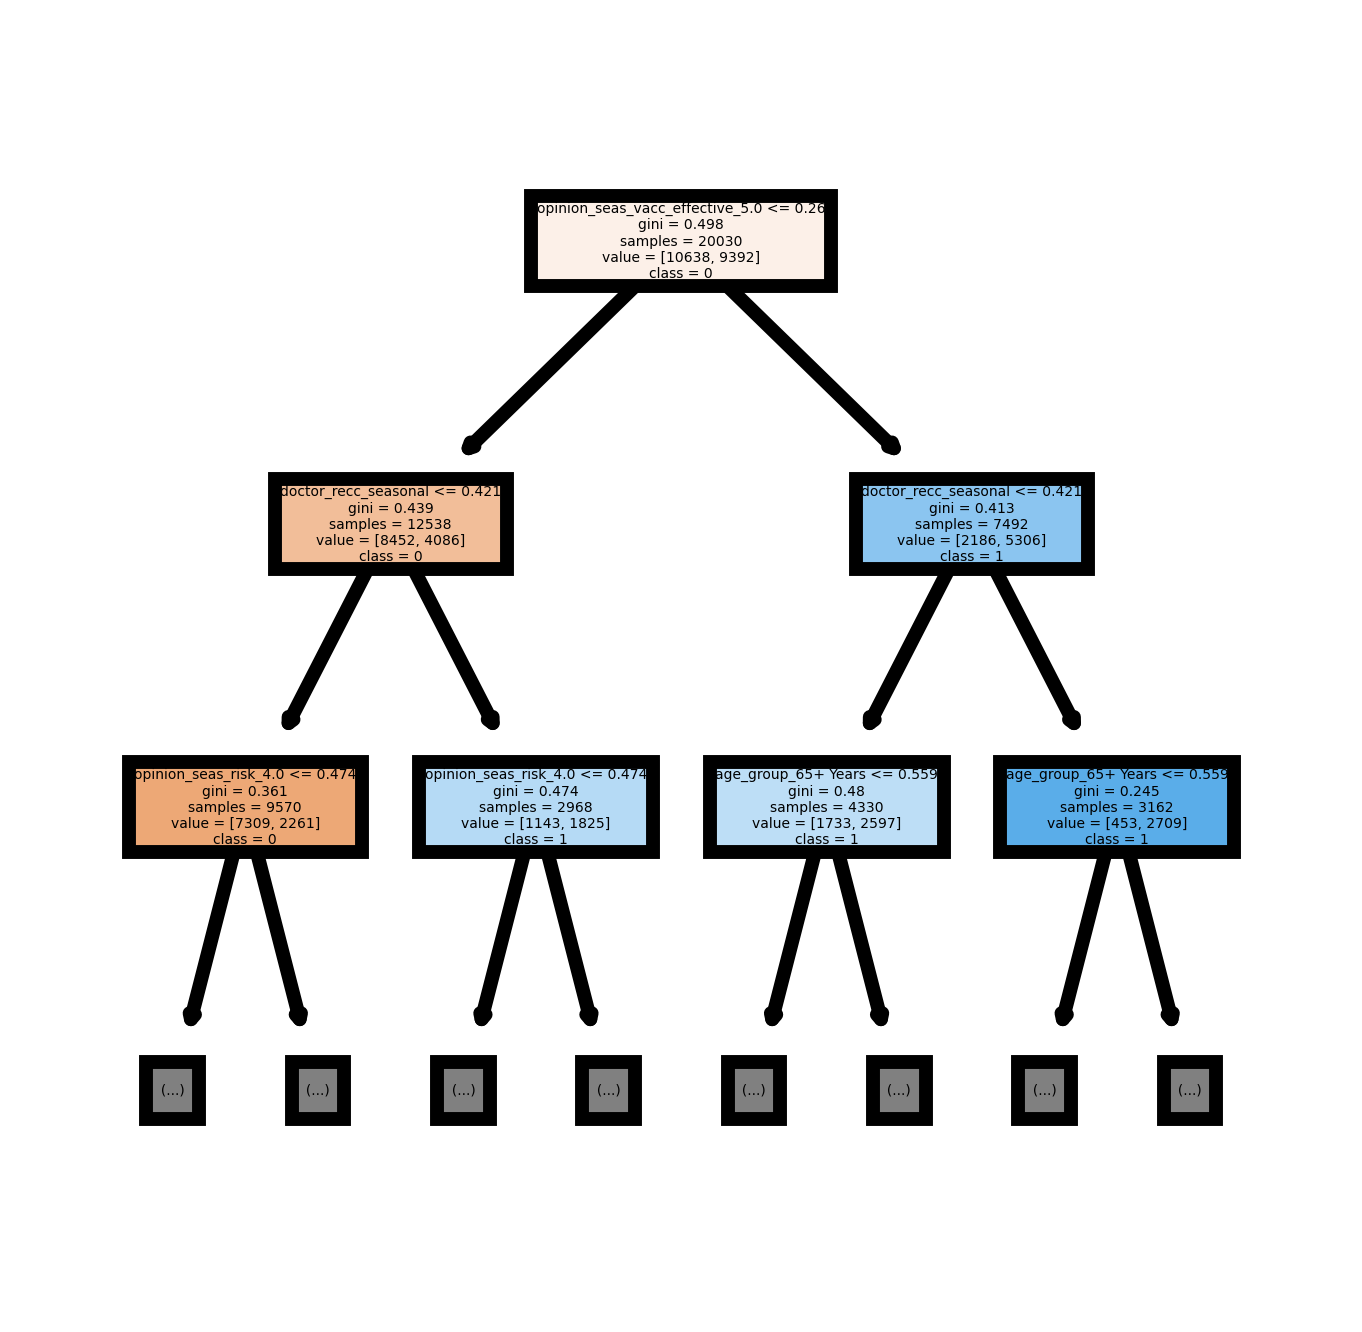

In [22]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (1.5,1.5), dpi=1000)
plot_tree(dt_final,
               max_depth = 2,
               feature_names = dt_keep_lists[4], 
               class_names=np.unique(y_train).astype('str'),
               filled = True)
plt.show()

### Random Forest  - Predictive Model

The team decided to use a random forest as the final model as it will improve upon the decision tree model. Random forests are ensemble models that can increase performance and decrease model overfitting.

Let's start by using grid search to find the optimal hyperparameters to use in the random forest.

In [23]:
RF = RandomForestClassifier()
param_grid_RF = {
      'n_estimators' : [10,100],
      'criterion' : ['gini', 'entropy'],
      'max_depth' : [50,100,500],
      'min_samples_split': [10,20,30],
      'random_state': [0,100,200]
}

gs_RF = GridSearchCV(RF, param_grid_RF, cv=5)
gs_RF.fit(X_train_pipe_processed, y_train)
gs_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_split': 30,
 'n_estimators': 100,
 'random_state': 0}

In order to find the top features to use, we will perform Recursive Feature Elimination (RFE) for Random Forest in the cell below.

In [24]:
RF_cv_rfe = []
RF_keep_lists = []
max_features = 20
for n in range(1,max_features+1):
    num_features_to_select = n
    RF_rfe = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30, n_estimators= 100,
                                    random_state = 0)
    select = RFE(RF_rfe, n_features_to_select=num_features_to_select)
    select.fit(X=X_train_pipe_processed, y=y_train)
    feature_list = [(k,v) for k,v in zip(X_train_pipe_processed.columns,select.support_)]
    current_keep_list = []
    for k,v in feature_list:
        if v:
            current_keep_list.append(k)
    
    current_cv = cross_val_score(RF_rfe,X_train_pipe_processed[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

    RF_cv_rfe.append(current_cv)
    RF_keep_lists.append(current_keep_list)

Let's plot the relationship between number of features and mean Cross Val Receiver Operating Characteristic (ROC) area under curve (AUC).

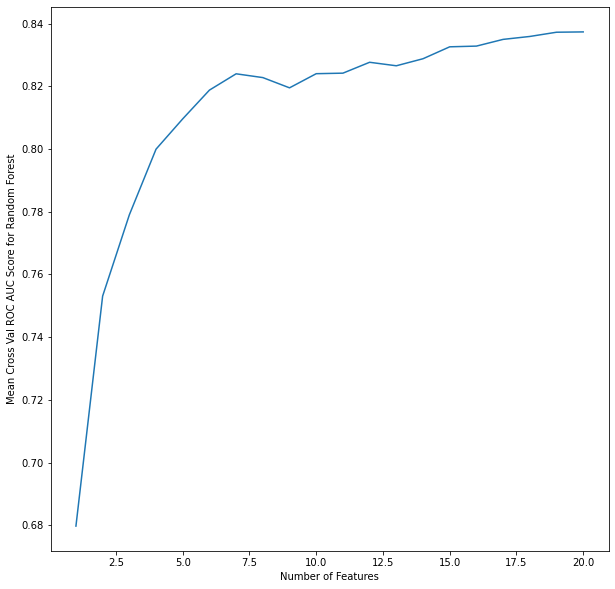

In [25]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range(1,max_features+1),RF_cv_rfe)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Mean Cross Val ROC AUC Score for Random Forest')
plt.show()

It appears that 20 features yields the maximum ROC AUC value.

Now that we have the top features and the best hyperparameters, we can generate the model and analyze it's performance.

In [26]:
RF_final = RandomForestClassifier(criterion = 'entropy', max_depth = 50, min_samples_split = 30,n_estimators= 100,
                                  random_state = 0)
RF_final.fit(X_train_pipe_processed[RF_keep_lists[19]],y_train)
cross_val_score(RF_final,X_train_pipe_processed[RF_keep_lists[19]],y_train,cv=5,scoring='roc_auc').mean()

0.8378119471925253

The average cross validation ROC AUC is 0.838 (83.8%), which is higher than the average cross validation ROC AUC of the Decision Tree (81%).

Let's also look at the test ROC AUC.

In [27]:
roc_auc_score(y_test,RF_final.predict(X_test_pipe_processed[RF_keep_lists[19]]))

0.7713205293924127

The test ROC AUC is 77.1%. Although the model is slightly overfitting, this model has a higher test ROC AUC than the decision tree model (75.2%).

Let's look at the confusion matrix to see how the model did on the training set.

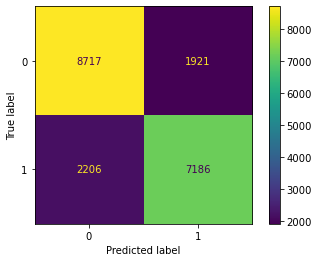

In [28]:
plot_confusion_matrix(RF_final,X_train_pipe_processed[RF_keep_lists[19]],y_train);

Let's now plot the ROC curve to visualize the area under the curve (AUC).

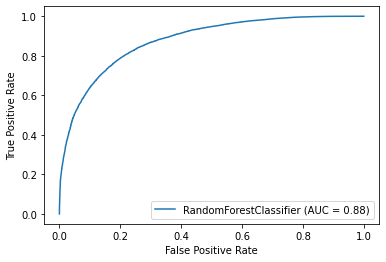

In [29]:
plot_roc_curve(RF_final,X_train_pipe_processed[RF_keep_lists[19]],y_train);

## Conclusion

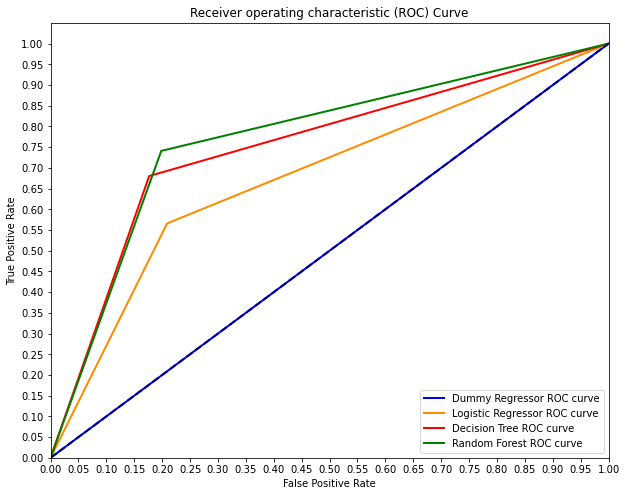

In [30]:
dc_test_fpr, dc_test_tpr, dc_test_thresholds = roc_curve(y_test,dc.predict(X_test_pipe_processed))
lr_test_fpr, lr_test_tpr, lr_test_thresholds = roc_curve(y_test,logreg_final.predict(X_test_pipe_processed[lr_keep_lists[0]]))
dt_test_fpr, dt_test_tpr, dt_test_thresholds = roc_curve(y_test,dt_final.predict(X_test_pipe_processed[dt_keep_lists[4]]))
RF_test_fpr, RF_test_tpr, RF_test_thresholds = roc_curve(y_test,RF_final.predict(X_test_pipe_processed[RF_keep_lists[19]]))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(dc_test_fpr, dc_test_tpr, color='blue',
         lw=lw, label='Dummy Regressor ROC curve')
plt.plot(lr_test_fpr, lr_test_tpr, color='darkorange',
         lw=lw, label='Logistic Regressor ROC curve')
plt.plot(dt_test_fpr, dt_test_tpr, color='red',
         lw=lw, label='Decision Tree ROC curve')
plt.plot(RF_test_fpr, RF_test_tpr, color='green',
         lw=lw, label='Random Forest ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()